

```
# This is formatted as code
```

ResNet 50

50 epoch

50k Dataset

LR = 0.0005

In [ ]:
pip install -U albumentations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.ops import MultiScaleRoIAlign, RoIPool
from torch.utils.data import DataLoader
import numpy as np
import os
import subprocess
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# Download training images
!wget http://images.cocodataset.org/zips/train2017.zip

# Download validation images
!wget http://images.cocodataset.org/zips/val2017.zip

# Download COCO annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-03-21 17:09:51--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.60.41, 3.5.8.222, 52.217.123.137, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.60.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip.2’

train2017.zip.2     100%[===================>]  18.01G  30.7MB/s    in 11m 21s 

2025-03-21 17:21:13 (27.1 MB/s) - ‘train2017.zip.2’ saved [19336861798/19336861798]

--2025-03-21 17:21:13--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.38.209, 3.5.29.64, 16.182.98.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.38.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.1’

val2017.zip.1       100%[===================>] 777

In [ ]:
!unzip -o train2017.zip
!unzip -o val2017.zip
!unzip -o annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/00000019

In [ ]:
# Custom Region Proposal Network (RPN)
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

In [ ]:
class BoxHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, 1024)  # ✅ Input should be 12544
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)  # ✅ Class logits
        self.bbox_pred = nn.Linear(1024, num_classes * 4)  # ✅ Bounding box regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_logits = self.cls_score(x)  # ✅ Class Scores
        bbox_preds = self.bbox_pred(x)  # ✅ Box Predictions
        return cls_logits, bbox_preds


In [ ]:
# Custom Mask Head (Fully Convolutional Layers)
class MaskHead(nn.Module):
    def __init__(self, in_channels, hidden_dim=256, num_classes=91):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(hidden_dim, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x


In [ ]:
import torchvision.models.detection.backbone_utils as backbone_utils
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_resnet_backbone():
    backbone = resnet_fpn_backbone("resnet50", weights="DEFAULT")  # ✅ Use ResNet50 with FPN
    return backbone


In [ ]:
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = get_resnet_backbone()  # ✅ Use Pretrained ResNet
        self.rpn = RPN(2048, num_anchors=9)
        self.roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)
        self.box_head = BoxHead(7 * 7 * 256, num_classes)  # ✅ Bounding Box Head
        self.mask_head = MaskHead(256, num_classes=num_classes)  # ✅ Mask Head

    def forward(self, images, proposals=None):
        features = self.backbone(images)  # ✅ Extract features

        # ✅ Fix `feature_dict` to correctly handle different backbone outputs
        if isinstance(features, dict):
            feature_dict = features  # ✅ Already a dictionary (FPN case)
        elif isinstance(features, list):
            feature_dict = {str(i): feat for i, feat in enumerate(features)}  # ✅ Convert list to dict
        else:
            feature_dict = {"0": features}  # ✅ Single tensor case (No FPN)

        # ✅ Generate proposals if not provided
        if proposals is None:
            rpn_logits, rpn_bbox = self.rpn(features)
            proposals = rpn_bbox

        # ✅ Fix `image_shapes` format
        image_shapes = [(images.shape[-2], images.shape[-1])] * images.shape[0]

        # ✅ Convert `proposals` into List[Tensor]
        proposals_per_image = []
        batch_size = images.shape[0]

        for i in range(batch_size):
            mask = proposals[:, 0] == i  # ✅ Select proposals for image `i`
            if mask.sum() == 0:  # ✅ Handle empty proposals
                proposals_per_image.append(torch.empty((0, 4), dtype=proposals.dtype, device=proposals.device))
            else:
                proposals_per_image.append(proposals[mask][:, 1:])  # ✅ Remove batch index column

        # ✅ Apply RoI Align
        pooled_regions = self.roi_pool(feature_dict, proposals_per_image, image_shapes)

        # ✅ Ensure `pooled_regions` is not empty
        if pooled_regions.numel() == 0:
            raise ValueError("❌ RoIAlign produced empty regions, check proposals input.")

        # ✅ Ensure correct shape before passing to BoxHead
        if pooled_regions.dim() != 4:
            raise ValueError(f"❌ Expected 4D tensor (N, C, 7, 7), got {pooled_regions.shape}")

        # ✅ Get feature map size
        C, H, W = pooled_regions.shape[1], pooled_regions.shape[2], pooled_regions.shape[3]
        expected_size = C * H * W  # Should be 256 * 7 * 7 = 12544

        # ✅ Ensure correct reshaping
        if expected_size != 12544:
            raise ValueError(f"❌ Feature map has incorrect channels: {C}. Expected 256.")

        flattened_pooled = pooled_regions.view(pooled_regions.size(0), expected_size)

        # ✅ Debugging Print (Optional)
        if batch_idx == 0:  # ✅ Print only for the first batch of each epoch
           print(f"✅ Reshaped pooled_regions: Expected {expected_size}, Got {flattened_pooled.shape[1]}")


        # ✅ Compute Class & Box Predictions
        class_logits, bbox_deltas = self.box_head(flattened_pooled)

        # ✅ Compute Mask Predictions
        masks = self.mask_head(pooled_regions)

        return class_logits, bbox_deltas, masks


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.ops import RoIAlign
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
import json
import time
from PIL import Image
from pycocotools.coco import COCO

# ✅ Set Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# ✅ COCO Dataset Class (Optimized)
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.img_ids = list(self.coco.imgs.keys())[:50000]  # ✅ Use only 20,000 images
        self.transform = transform
        self.img_size = (128, 128)  # ✅ Resize to 128x128 for faster training

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # ✅ Resize image
        image = image.resize(self.img_size, Image.BILINEAR)

        # Get bounding boxes & masks
        boxes, masks, labels = [], [], []

        for ann in anns:
            x, y, w, h = ann['bbox']
            x1, y1, x2, y2 = x, y, x + w, y + h
            boxes.append([x1, y1, x2, y2])

            mask = self.coco.annToMask(ann)
            mask = cv2.resize(mask, self.img_size)  # Resize mask
            masks.append(mask)

            labels.append(ann['category_id'])

        # ✅ Handle Empty Annotations
        if len(boxes) == 0 or len(labels) == 0:
            return self.__getitem__((idx + 1) % len(self.img_ids))  # Skip empty images

        # ✅ Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32).reshape(-1, 4)  # Shape (N, 4)
        masks = torch.tensor(np.array(masks), dtype=torch.uint8).unsqueeze(1)  # Shape (N, 1, H, W)
        labels = torch.tensor(labels, dtype=torch.int64).flatten()  # Shape (N,)

        if self.transform:
            image = self.transform(image)

        return image, boxes, masks, labels

# ✅ Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.RandomHorizontalFlip(p=0.5),  # ✅ Flip images randomly
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # ✅ Improve feature learning
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # ✅ Reduce noise
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ✅ Normalize using ImageNet stats
])

# ✅ Collate Function to Handle Variable-Sized Batches
def collate_fn(batch):
    images, boxes, masks, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    return images, boxes, masks, labels  # Keep boxes/masks/lables as lists

# ✅ Create Dataset & DataLoader (Optimized)
train_dataset = COCODataset("train2017", "annotations/instances_train2017.json", transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# ✅ Check Dataset
print(f"Total images in dataset: {len(train_dataset)}")
for images, boxes, masks, labels in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Boxes shape: {boxes[0].shape}")
    print(f"Masks shape: {masks[0].shape}")
    print(f"Labels: {labels[0]}")
    break  # ✅ Stop after first batch check


Using Device: cuda
loading annotations into memory...
Done (t=16.07s)
creating index...
index created!
Total images in dataset: 50000
Batch size: 16
Image shape: torch.Size([3, 128, 128])
Boxes shape: torch.Size([5, 4])
Masks shape: torch.Size([5, 1, 128, 128])
Labels: tensor([16, 15, 15, 15, 62])


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms


# ✅ Load Model & Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskRCNN(num_classes=91).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ✅ Loss Functions
loss_fn_cls = nn.CrossEntropyLoss(label_smoothing=0.2)
loss_fn_bbox = nn.SmoothL1Loss()
loss_fn_mask = nn.BCEWithLogitsLoss()

scaler = GradScaler()

# ✅ Training Loop
epochs = 50
accumulate_steps = 4

train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    total_loss, correct_preds, total_preds = 0, 0, 0

    for batch_idx, (images, boxes, masks, labels) in enumerate(train_loader):
        images = torch.stack([img.to(device) for img in images])
        boxes = [b.to(device) for b in boxes]
        masks = [m.to(device) for m in masks]
        labels = [l.to(device) for l in labels]

        # ✅ Skip Empty Labels to Prevent Errors
        if len(labels) == 0 or len(boxes) == 0:
            print(f"⚠️ Skipping batch {batch_idx} due to empty labels/boxes")
            continue

        # ✅ Normalize & Clamp Bounding Boxes
        for i in range(len(boxes)):
            image_w, image_h = images.shape[3], images.shape[2]
            boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
            boxes[i] = torch.clamp(boxes[i], min=0, max=1)

        num_proposals = min(15, max(len(b) for b in boxes))
        proposals, proposal_labels, proposal_boxes = [], [], []

        for i, (b, l) in enumerate(zip(boxes, labels)):
            if len(b) == 0:
                continue
            b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
            formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
            proposals.append(formatted_boxes[:num_proposals])
            proposal_labels.append(l[:num_proposals])
            proposal_boxes.append(b[:num_proposals])

        if len(proposals) > 0:
            proposals = torch.cat(proposals, dim=0).to(device)
            proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
            proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
        else:
            proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
            proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
            proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

        # ✅ Forward Pass with Mixed Precision
        with autocast():
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

        # ✅ Compute Losses
        loss_cls = loss_fn_cls(class_logits, proposal_labels)
        selected_bbox_deltas = bbox_deltas.view(-1, 91, 4)
        predicted_classes = torch.argmax(class_logits, dim=1)
        selected_bbox_deltas = selected_bbox_deltas[torch.arange(selected_bbox_deltas.size(0)), predicted_classes]
        loss_bbox = loss_fn_bbox(selected_bbox_deltas, proposal_boxes)

        resized_masks = F.interpolate(masks[0].float(), size=mask_logits.shape[-2:], mode="bilinear", align_corners=False)

        # ✅ Ensure masks match mask_logits channels
        if resized_masks.shape[1] == 1 and mask_logits.shape[1] > 1:
            resized_masks = resized_masks.repeat(1, mask_logits.shape[1], 1, 1)
        elif resized_masks.shape[1] > 1 and mask_logits.shape[1] == 1:
            resized_masks = resized_masks[:, :1, :, :]

        # ✅ Ensure batch sizes match
        if resized_masks.shape[0] < mask_logits.shape[0]:
            pad_size = mask_logits.shape[0] - resized_masks.shape[0]
            padding = torch.zeros((pad_size, mask_logits.shape[1], *mask_logits.shape[-2:]), dtype=resized_masks.dtype, device=resized_masks.device)
            resized_masks = torch.cat([resized_masks, padding], dim=0)
        elif resized_masks.shape[0] > mask_logits.shape[0]:
            resized_masks = resized_masks[:mask_logits.shape[0]]

        loss_mask = loss_fn_mask(mask_logits, resized_masks)

        # ✅ Total Loss (Normalized)
        loss = (loss_cls + loss_bbox + loss_mask) / len(images)

        # ✅ Convert NaN Losses to Zero & Skip Unstable Batches
        loss = torch.nan_to_num(loss, nan=0.0, posinf=0.0, neginf=0.0)
        if loss == 0 or torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️ Skipping batch {batch_idx} due to unstable loss")
            optimizer.zero_grad()
            continue

        # ✅ Gradient Accumulation with Clipping
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        if (batch_idx + 1) % accumulate_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(class_logits, dim=1)
        labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

        # ✅ Track Accuracy
        min_size = min(labels_flat.shape[0], preds.shape[0])
        correct_preds += (preds[:min_size] == labels_flat[:min_size]).sum().item()
        total_preds += min_size

        if batch_idx % 100 == 0:
            print(f"🟢 Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")

    # ✅ Compute Training Accuracy
    scheduler.step()
    train_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0
    train_losses.append(total_loss)
    train_accuracies.append(train_accuracy)
    epoch_time = time.time() - start_time

    print(f"✅ Epoch {epoch+1} Done: Loss {total_loss:.4f}, Train Acc: {train_accuracy:.4f}, Time: {epoch_time:.2f}s")

    # ✅ Print Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"📉 Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]
<ipython-input-14-93e5960eda60>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-14-93e5960eda60>:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Streaming output truncated to the last 5000 lines.
⚠️ Skipping batch 803 due to unstable loss
⚠️ Skipping batch 812 due to unstable loss
⚠️ Skipping batch 818 due to unstable loss
⚠️ Skipping batch 831 due to unstable loss
⚠️ Skipping batch 835 due to unstable loss
⚠️ Skipping batch 848 due to unstable loss
⚠️ Skipping batch 850 due to unstable loss
⚠️ Skipping batch 851 due to unstable loss
⚠️ Skipping batch 852 due to unstable loss
⚠️ Skipping batch 867 due to unstable loss
⚠️ Skipping batch 874 due to unstable loss
⚠️ Skipping batch 875 due to unstable loss
⚠️ Skipping batch 877 due to unstable loss
⚠️ Skipping batch 888 due to unstable loss
🟢 Epoch 34, Batch 900/3125: Loss 0.1757
⚠️ Skipping batch 919 due to unstable loss
⚠️ Skipping batch 944 due to unstable loss
⚠️ Skipping batch 950 due to unstable loss
⚠️ Skipping batch 959 due to unstable loss
⚠️ Skipping batch 961 due to unstable loss
⚠️ Skipping batch 962 due to unstable loss
⚠️ Skipping batch 980 due to unstable loss
🟢 Epoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path =  "/content/drive/MyDrive/mask_resnet50_50K_50.pth"  # Change path if needed
torch.save(model.state_dict(), save_path)

print(f"✅ Model saved to Google Drive at {save_path}")

Mounted at /content/drive
✅ Model saved to Google Drive at /content/drive/MyDrive/mask_resnet50_50K_50.pth


In [ ]:
# Load the model for inference or continued training
model = MaskRCNN(num_classes=91).to(device)  # Initialize the model again

# Load the saved weights (state_dict)
checkpoint_path = "/content/drive/MyDrive/mask_resnet50_50K_50.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

MaskRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, ep

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate
from collections import Counter

# ✅ Create Dataset & DataLoader (Optimized)
test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

import torch

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for testing
        for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
            images = torch.stack([img.to(device) for img in images])
            boxes = [b.to(device) for b in boxes]
            masks = [m.to(device) for m in masks]
            labels = [l.to(device) for l in labels]

            # Skip Empty Labels to Prevent Errors
            if len(labels) == 0 or len(boxes) == 0:
                print(f"⚠️ Skipping batch {batch_idx} due to empty labels/boxes")
                continue

            # Normalize & Clamp Bounding Boxes
            for i in range(len(boxes)):
                image_w, image_h = images.shape[3], images.shape[2]
                boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
                boxes[i] = torch.clamp(boxes[i], min=0, max=1)

            num_proposals = min(15, max(len(b) for b in boxes))
            proposals, proposal_labels, proposal_boxes = [], [], []

            for i, (b, l) in enumerate(zip(boxes, labels)):
                if len(b) == 0:
                    continue
                b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
                formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
                proposals.append(formatted_boxes[:num_proposals])
                proposal_labels.append(l[:num_proposals])
                proposal_boxes.append(b[:num_proposals])

            # Ensure proposals is a tensor before indexing
            if len(proposals) > 0:
                proposals = torch.cat(proposals, dim=0).to(device)
                proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
                proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
            else:
                proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
                proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
                proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

            # Forward Pass with Mixed Precision
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

            preds = torch.argmax(class_logits, dim=1)
            labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

            # Track predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_flat.cpu().numpy())

            if batch_idx % 100 == 0:
                print(f"🟢 Test Batch {batch_idx}/{len(test_loader)}")

    # Calculate accuracy
    correct_preds = sum((np.array(all_preds) == np.array(all_labels)).astype(int))
    total_preds = len(all_labels)
    test_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0

    print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Example usage
test_model(model, test_loader, device)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
🟢 Test Batch 0/313
🟢 Test Batch 100/313
🟢 Test Batch 200/313
🟢 Test Batch 300/313
✅ Test Accuracy: 0.4563


In [ ]:
train_losses

[733.6744941323996,
 683.5249000787735,
 656.5675865411758,
 624.6553384065628,
 609.443319991231,
 593.0933747142553,
 584.4057718962431,
 579.3187127262354,
 572.4222359061241,
 574.0508576780558,
 564.7448119968176,
 567.8717444837093,
 569.182909399271,
 574.4724337607622,
 570.7166020721197,
 572.2241363972425,
 567.2048589736223,
 569.3906896114349,
 568.1683320254087,
 566.124853849411,
 567.0226359665394,
 557.5343243479729,
 556.7001314610243,
 571.5563227832317,
 556.2904403060675,
 538.0590338408947,
 525.6957822144032,
 515.95223107934,
 512.4767888784409,
 509.1619621217251,
 506.1503067910671,
 513.2282740324736,
 511.8225350379944,
 508.74630030989647,
 517.3472691476345,
 516.7809957712889,
 520.7673632353544,
 519.1671275645494,
 521.8077923357487,
 531.7654455602169,
 530.2034233510494,
 522.7497258782387,
 522.8500550538301,
 513.816053763032,
 505.3454407155514,
 496.1213708370924,
 496.3458838015795,
 488.59472143650055,
 483.83175675570965,
 486.9570259451866]

In [ ]:
train_accuracies

[0.3007207381318121,
 0.310544408941384,
 0.3181570986710173,
 0.33013094393800485,
 0.3388433792154644,
 0.35355770514144413,
 0.3630165810958674,
 0.3670625616763366,
 0.374333567076716,
 0.3759102387431186,
 0.3764068823380232,
 0.37750612805871603,
 0.37857998918181274,
 0.3762970576718689,
 0.3776870459727451,
 0.3765075128509292,
 0.37989132364953654,
 0.3787027461182249,
 0.38351180985444944,
 0.3843953509005412,
 0.38837448197738644,
 0.39533980167245303,
 0.3956015376448667,
 0.3879587973547705,
 0.3996404523067431,
 0.4208431920843192,
 0.43818831019846277,
 0.4472698121352162,
 0.45456914523974984,
 0.4567088000174495,
 0.4580495792685831,
 0.45906637004875567,
 0.45741458031289894,
 0.4533852555914636,
 0.452396884068602,
 0.4461889912248894,
 0.44342794815026165,
 0.44435497557259074,
 0.44158440855364073,
 0.433610698789678,
 0.433197742702455,
 0.4456401074306177,
 0.44231917848635965,
 0.45081212384888697,
 0.4657648237860758,
 0.4705040957317388,
 0.4771621907379996,
 

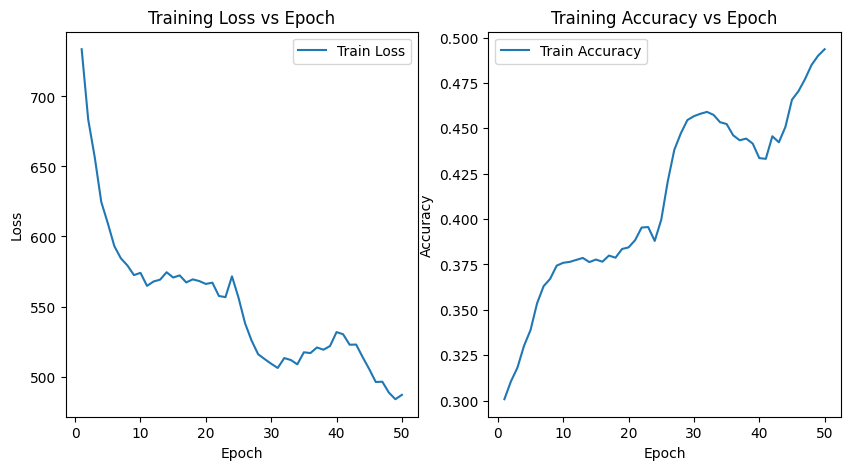

In [ ]:
# ✅ Plot Training and Testing Metrics
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
# plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss vs Epoch")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
# plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy vs Epoch")

plt.show()

In [ ]:
import torch
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# ✅ Define the Model Exactly as Used During Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the backbone first
backbone = resnet_fpn_backbone('resnet50', pretrained=False)

# Create the model
model = MaskRCNN(backbone, num_classes=91)  # Ensure num_classes matches training
model.to(device)

# ✅ Load the Correct Weights
checkpoint_path = "/content/drive/MyDrive/mask_resnet50_50K_50.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# ✅ Filter Weights to Match Model Keys
model_dict = model.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
model.load_state_dict(filtered_state_dict, strict=False)  # Allow missing keys

# ✅ Set Model to Evaluation Mode
model.eval()
print("✅ Model weights loaded successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model weights loaded successfully!


In [ ]:
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ List of Selected Images
selected_images = [
    "000000335529.jpg", "000000477623.jpg", "000000052017.jpg",
    "000000095899.jpg", "000000295797.jpg", "000000104572.jpg", "000000051008.jpg",
    "000000453722.jpg", "000000000785.jpg"
]

# ✅ Function to Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Apply Bilateral Filter (Preserves Edges)
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)

    # Convert back to 3-channel image
    processed_image = cv2.cvtColor(filtered, cv2.COLOR_GRAY2RGB)

    # Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale values
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect, Mask, and Draw Bounding Boxes Around Objects
def detect_masked_regions(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # Define Mask Color Range
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for idx, cnt in enumerate(contours):
        if cv2.contourArea(cnt) < 500:  # Ignore small areas to remove noise
            continue

        # Generate a random color for each object
        random_color = [np.random.randint(50, 255), np.random.randint(50, 255), np.random.randint(50, 255)]

        # Create a translucent mask following object shape
        alpha = 0.3
        mask_shape = np.zeros_like(image_np, dtype=np.uint8)
        cv2.drawContours(mask_shape, [cnt], -1, random_color, thickness=cv2.FILLED)

        # Apply transparency to the object shape
        image_np = cv2.addWeighted(image_np, 1, mask_shape, alpha, 0)

        # Draw contour outline
        cv2.drawContours(image_np, [cnt], -1, random_color, 2)

        # Get bounding box for the detected object
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_np, (x, y), (x + w, y + h), random_color, 2)

        # Add Label at the center of the object
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX, cY = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
            cv2.putText(image_np, f"Obj {idx+1}", (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return image_np

# ✅ Visualization Function with Image Number
def visualize_predictions(image_number, original_image, original_size, outputs, threshold=0.8):
    image_np = np.array(original_image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Apply Mask Using Object Shape and Draw Bounding Boxes
    image_np = detect_masked_regions(image_np)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Processed Image {image_number}")
    plt.show()

# ✅ Set Folder Path Containing Images
folder_path = "val2017"  # Change this if needed

# ✅ Process and Predict on the Selected Images
for i, image_name in enumerate(selected_images, start=1):
    image_path = os.path.join(folder_path, image_name)

    if not os.path.exists(image_path):
        print(f"⚠️ Image {image_name} not found, skipping.")
        continue

    print(f"Processing Image {i}: {image_path}")

    image_tensor, original_image, original_size = preprocess_image(image_path)

    with torch.no_grad():
        outputs = model(image_tensor)[0]

    visualize_predictions(i, original_image, original_size, outputs)  # Display with image number


Output hidden; open in https://colab.research.google.com to view.